# Anomaly Detection using a Histogram Model

In the [*last part*](https://github.com/mclarknc/Anomaly-Detection/blob/master/Anomaly%20Detection%20-%20Smoothing.ipynb) of this series, we found that using cluster centroids from windowed segments of our training data, we could detect anomalous values in our water tank data, but *only* if the data sample begins and ends on or close to zero. In this part, we will experiment with a different, simpler model based on a histogram of historical water tank data.


In [1]:
# import modules and initialize plotting parameters
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 10

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = "sans serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{subdepth}, \usepackage{type1cm}"

Ingest our water tank data, and split it into a training and testing sets.

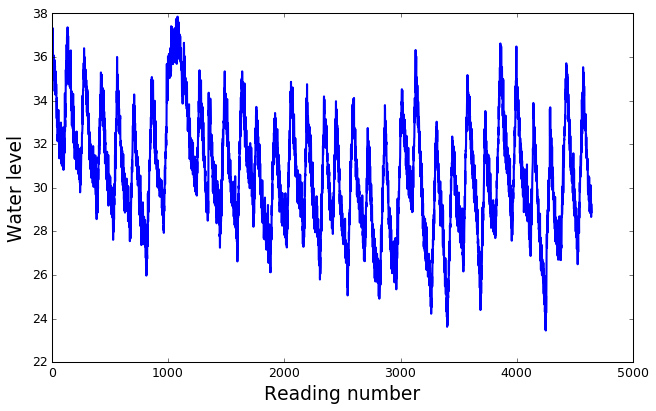

In [2]:
data = open('watertank_data.csv').readlines()
points = [float(p.strip()) for p in data]
all_data = np.array(points)
# lets take half of the input data for training, and half for testing
# and create numpy arrays
half = int(len(points)/2)
train_data = all_data[:half]
test = all_data[half:]

#plt.figure(figsize=(16, 10))
plt.plot(train_data)
plt.xlabel("Reading number")
plt.ylabel("Water level")

Cluster the individual observations into say, 100 buckets

In [3]:
bins = 100
ordered = sorted(train_data)
div = len(ordered) // bins
chunks = [ ordered[int(round(div * i)): int(round(div * (i + 1)))] for i in range(bins) ]
meds = [np.median(chunk) for chunk in chunks]


Let's examine our histogram:

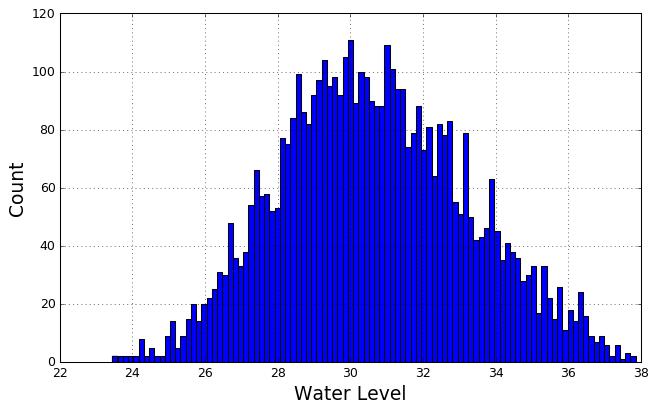

In [4]:
n, bins, patches = plt.hist(ordered,100)
plt.grid()
plt.xlabel('Water Level')
plt.ylabel('Count')

Looks like a nice normal distribution. Just for giggles, let's get some basis stats.

In [5]:
print('Minumum reading = {} ft., maximum = {} ft.'.format(np.amin(ordered), np.amax(ordered)))
print('Mean of water level = {:0.2f} ft.'.format(np.mean(ordered)))
print('Standard deviation = {:0.2f} ft.'.format(np.std(ordered)))

Minumum reading = 23.45 ft., maximum = 37.85 ft.
Mean of water level = 30.64 ft.
Standard deviation = 2.59 ft.


In [6]:
# define a function to return the nearest value in a list
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

Now reconstruct the original data using the medians of the chunked data

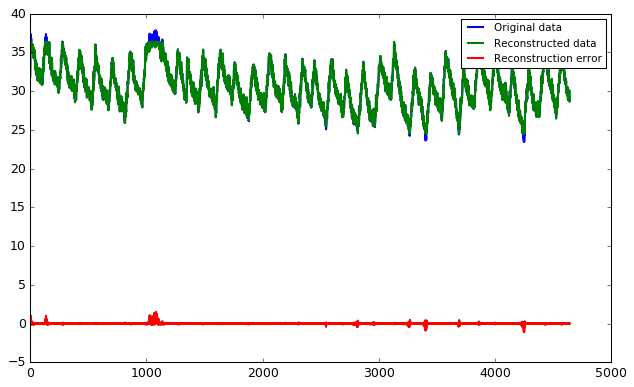

In [7]:
reconstructed = [find_nearest(meds, val) for val in train_data]
error = train_data - reconstructed
plt.plot(train_data, label="Original data")
plt.plot(reconstructed, label="Reconstructed data")
plt.plot(error, label="Reconstruction error")
plt.legend()

Looking good!  Let's get the max and 99th percentile of the reconstruction error:

In [8]:
max_error = np.absolute(error).max()
error_99th_percentile = np.percentile(error, 99)
        
print('The maxiumum reconstruction error is: {:0.2f}'.format(max_error))
print('The 99th percentile of reconstruction error is: {:0.2f}'.format(error_99th_percentile))

The maxiumum reconstruction error is: 1.51
The 99th percentile of reconstruction error is: 0.27


It appears that we could choose a threshold at the 99th percentile of our reconstruction error and call anything above that "anomalous", which would be a very sensitive detector. 

## Using the test data set

Since we "trained" our model on the training half of our water tank data, let's test it on the test half of the data. Additionally, let's introduce an anomaly similar to what we might expect to see if the pump station supplying the water tank failed, and the tank level dropped below normal.

First, we create  a "ramp" of data 100 points beginning at the value of the test data 100 points from the end down to zero, and substitute it for the last 100 readings in the test data. 

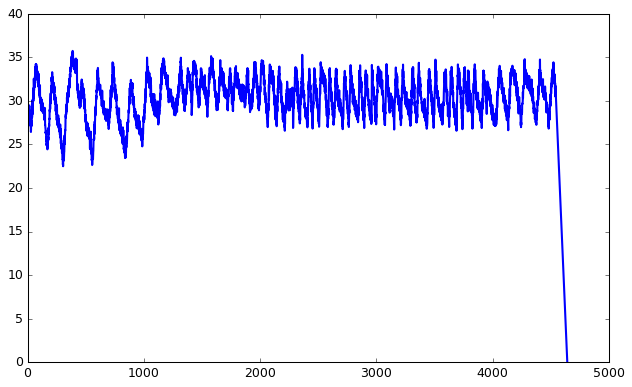

In [9]:
ramp = np.linspace(test[-100], 0, 100)
test[-100:] = ramp
plt.plot(test)

Now test it against our model and examine the reconstruction error.

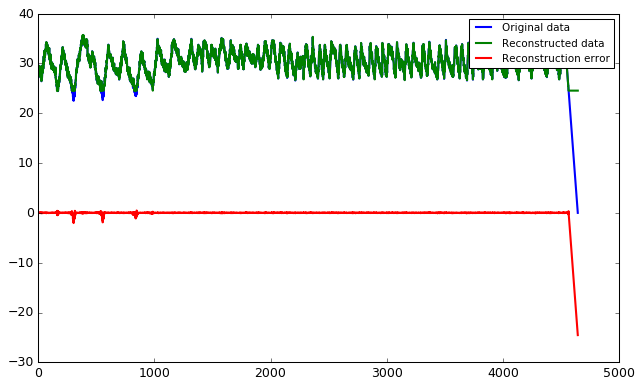

In [10]:
test_reconstructed = [find_nearest(meds, val) for val in test]
test_error = test - test_reconstructed
plt.plot(test, label="Original data")
plt.plot(test_reconstructed, label="Reconstructed data")
plt.plot(test_error, label="Reconstruction error")
plt.legend()

The reconstruction error for the "normal" portion of the test data looks quite low, but explodes when the tank level falls below the median of the lowest bucket in our histogram.

## Conclusion

Using the histogram model for anomaly detection in our water tank example seems to work well without suffering the problems encountered when using the KMeans clustered and windowed model. By comparing each incoming sensor reading by the median values of the highest and lowest histogram bins, we could build an effective real-time anomaly detector for our water tank. It could be argued that we could simply pick an upper and lower threshold for the data by inspection and test each incoming reading against those thresholds, so why bother with building and training the model? The answer is that this technique allows automatic selection of the upper and lower threshold values without user intervention.